# Identifying and describing spatial communities with spatial statistics

*TL;DR we provide an overview of spatial statistics for the analysis of spatial omics data*

## Background
When dealing with spatial omics dataset, we might be interested in identifying *spatial patterns* in the data, that is, identifying features that vary in *space*. 
**Spatial statistics** [CITE] are quantitative scores that can be used to identify spatial patterns in the tissue.
Here, we'll take a look at various spatial statistics implemented in Squidpy with a different set of spatial omics data.

## Datasets
We'll be using 2 datasets for this section. They can be easily downloaded with Squidpy. Let's initialize the variables and take a quick look at the data.

### Mibitof
This dataset consists of 3 tissue slides from 2 donors and 8 cell types. The dataset was originally published by [CITE] and was pre-processed in Squidpy.

In [21]:
import squidpy as sq
import scanpy as sc

sc.set_figure_params(figsize=(5, 5))

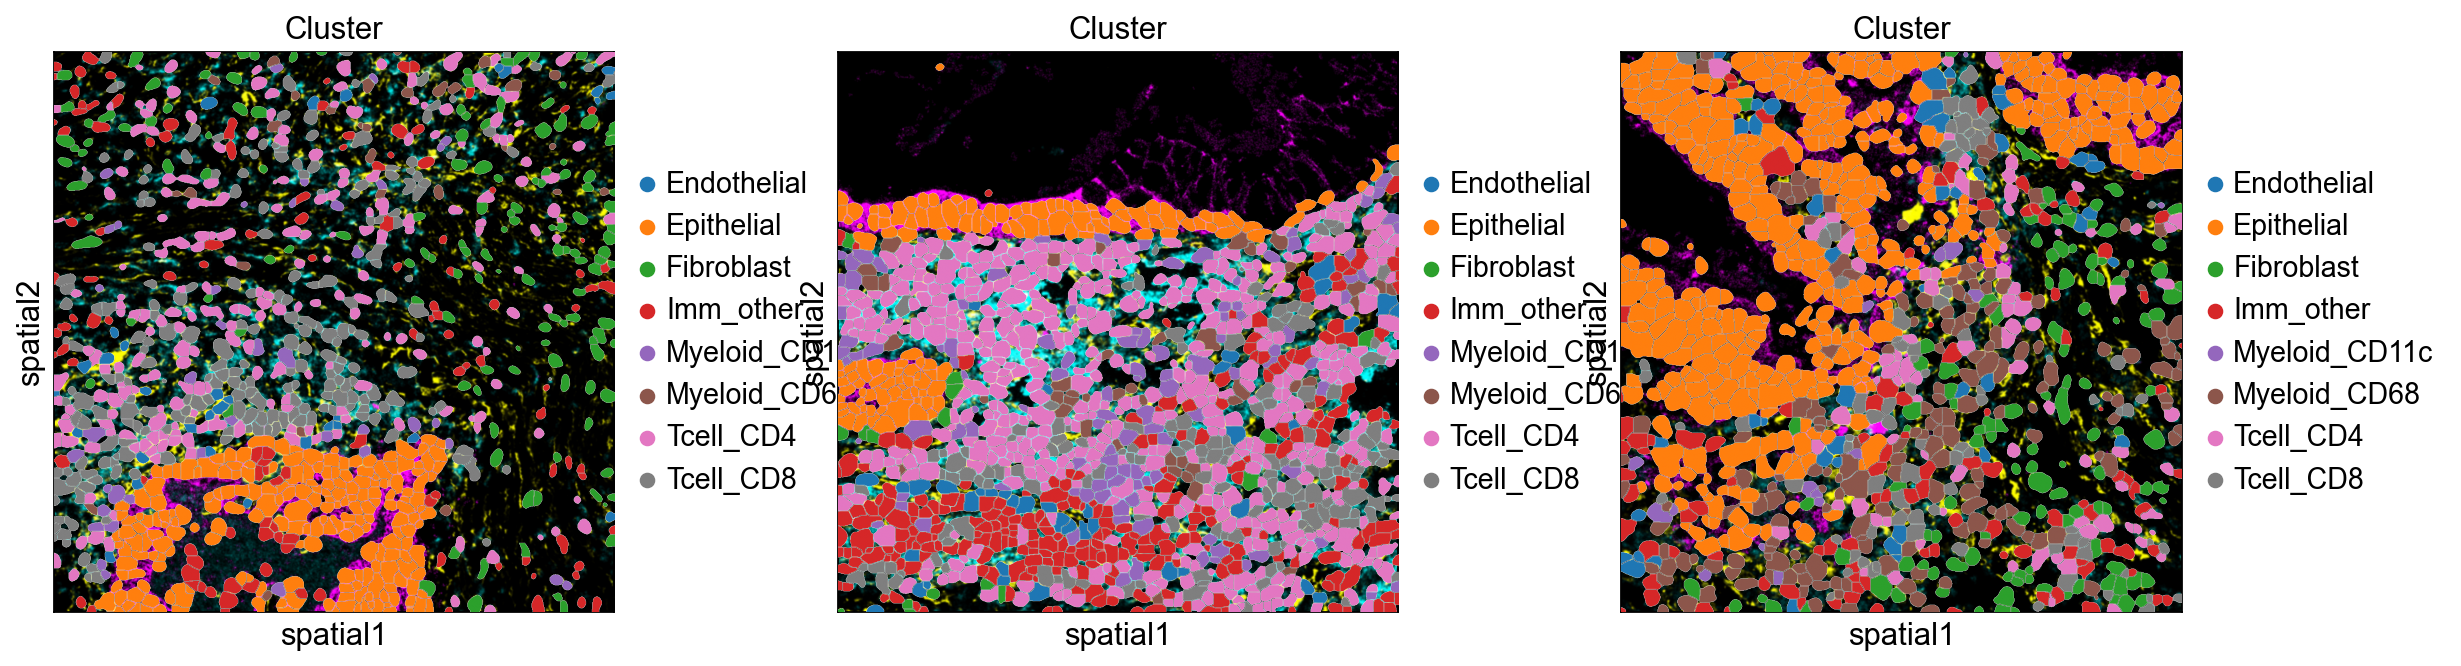

In [22]:
mibitof = sq.datasets.mibitof()
sq.pl.spatial_segment(
    mibitof, library_key="library_id", color="Cluster", seg_cell_id="cell_id"
)

### Visium
This dataset consists of 1 tissue slides from 1 mouse. The dataset was originally published in [CITE] and was pre-processed in Squidpy.

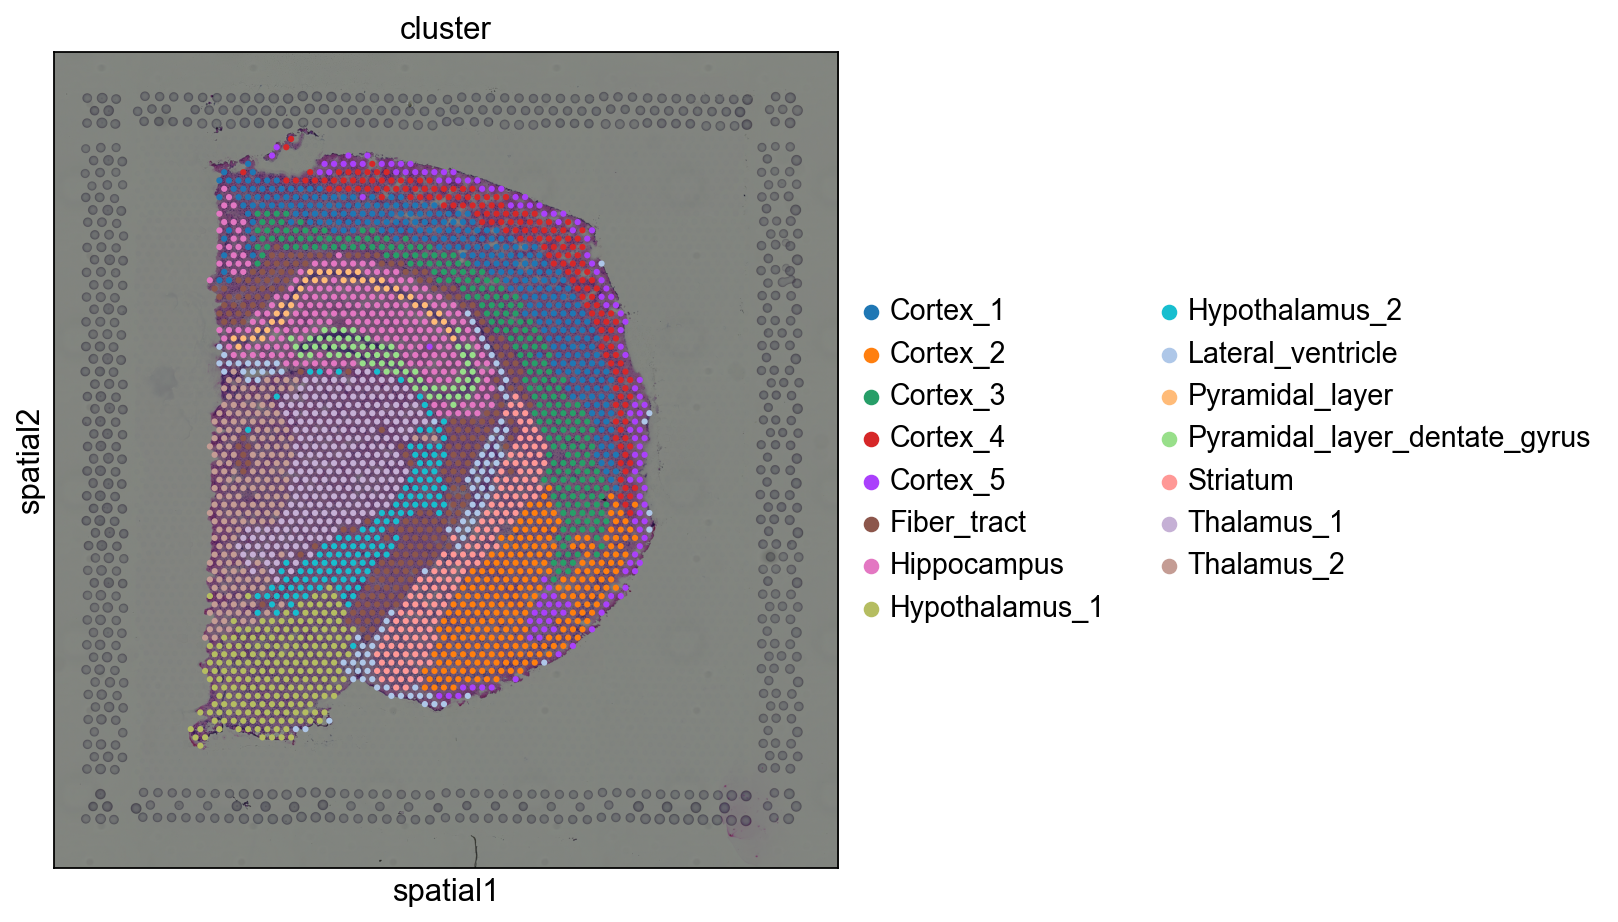

In [25]:
visium = sq.datasets.visium_hne_adata()
sq.pl.spatial_scatter(visium, color="cluster", figsize=(10, 10))

## Identifying interactions between spatial communities
After annotating cell types or cell states in the dataset (or spots, according to the technology at end), we can quantify whether such annotations are spatially enriched. 
To this end, Computing a neighborhood enrichment can help us identify clusters that are neighbors in the tissue of interest. 
In short, it’s an enrichment score on spatial proximity of clusters: if observations (cells or spots) belonging to a cluster are often close to observations belonging to 
another cluster, then they will have a high score and will appear to be enriched. On the other hand, if they are far apart, and therefore are seldom neighbors, the score will be low and they can be defined as depleted.
This score is based on a permutation-based test, and you can set the number of permutations with the n_perms argument (default is 1000).

Since the function works on a spatial connectivity matrix (spatial graph), we need to compute that as well. This can be done with `squidpy.gr.spatial_neighbors()`.

Finally, we’ll directly visualize the results with squidpy.pl.nhood_enrichment().


100%|██████████| 1000/1000 [00:06<00:00, 148.25/s]
/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


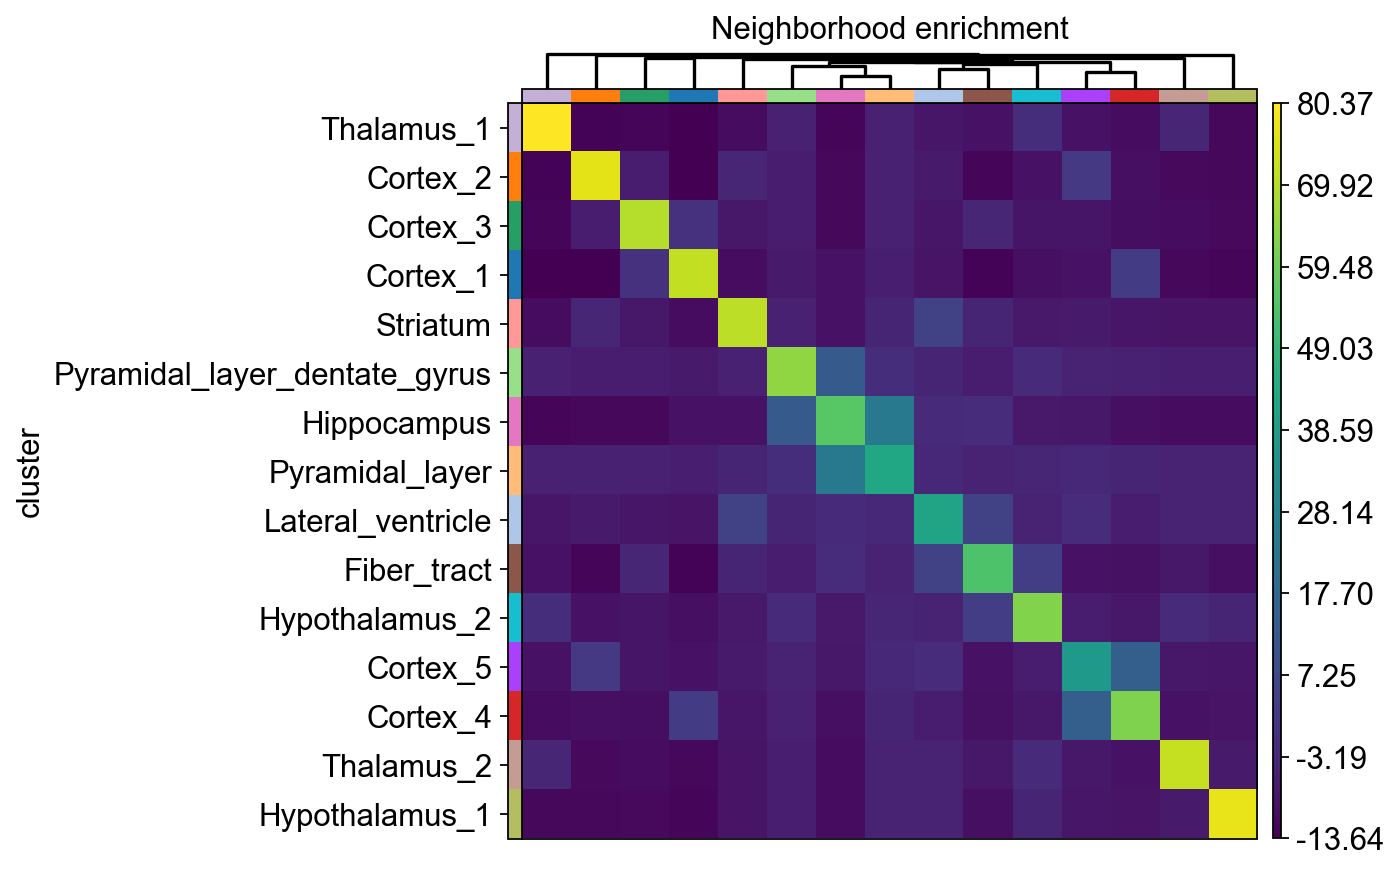

In [33]:
sq.gr.spatial_neighbors(visium)
sq.gr.nhood_enrichment(visium, cluster_key="cluster")
sq.pl.nhood_enrichment(
    visium, cluster_key="cluster", method="average", figsize=(5, 5)
)  # `method` compute the hierarchical clustering dendrogram for the heatmap

From the above plot, we can see that there seems to be an enrichment for clusters of the `Pyramidal_layer` and `Dentate_gyrus`. By looking at the spatial scatterplot above, we can confirm that these clusters are indeed "neighbors" as their members are often close.

Let's perform the same analysis on the `mibitof` dataset. Since this dataset consists of 3 tissue slides, we can perform the analysis jointly on all the three slides together. To achieve this, we can first compute a spatial graph for all 3 slides, and then compute the same function as above.

100%|██████████| 1000/1000 [00:07<00:00, 135.22/s]
/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


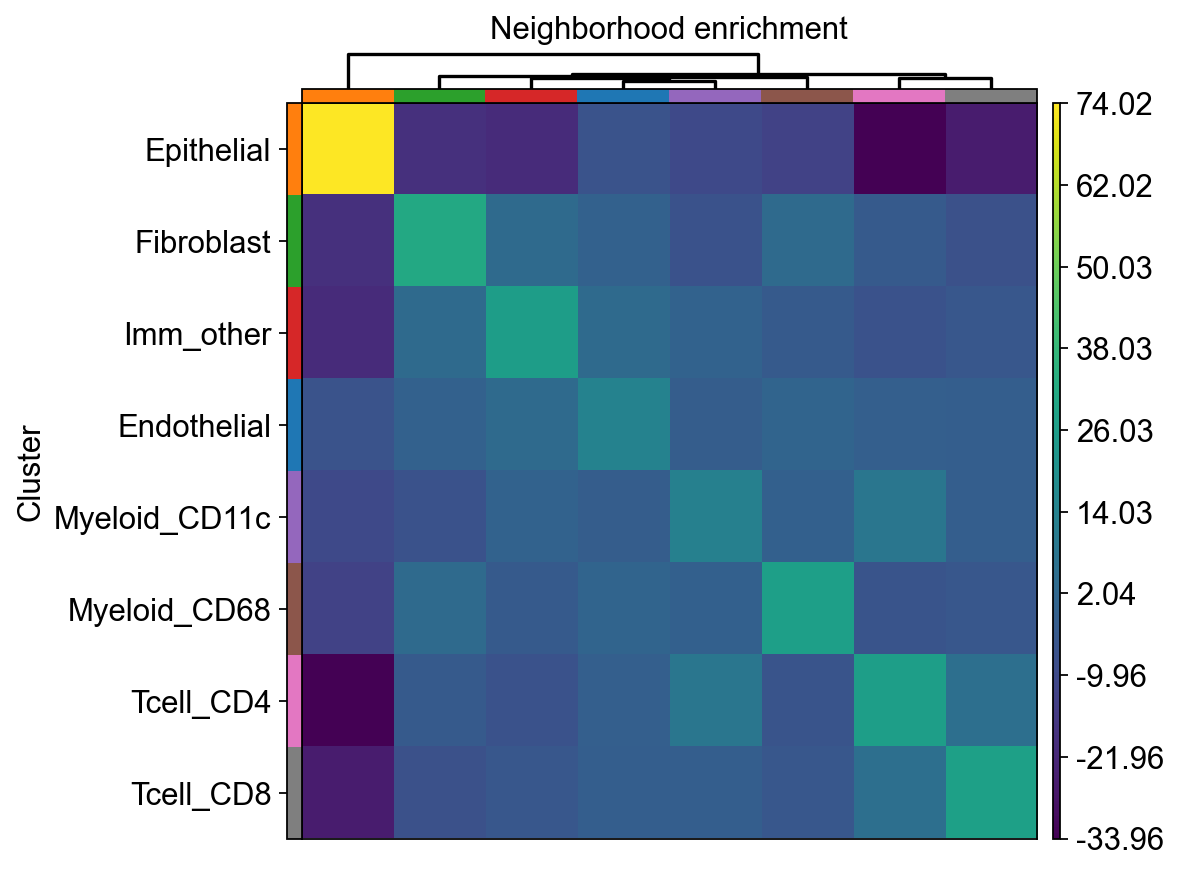

In [32]:
sq.gr.spatial_neighbors(
    mibitof, coord_type="generic", library_key="library_id", delaunay=True
)
sq.gr.nhood_enrichment(mibitof, cluster_key="Cluster")
sq.pl.nhood_enrichment(mibitof, cluster_key="Cluster", method="average")

The cluster `Epithelial` seems to show a strong enrichment with itself, confirming the visual intuition from the segmentation plot above. In contrast, the other clusters do not seem to show a specific enrichment.

A similar approach to such problem is computing what we call an *interaction matrix*, that is, the sum of all connecting observations between clusters in tissue. Such approach is related to the neighborood enrichment analysis yet it is not a test, but should be viewed as a simple summary statistics of the spatial graph.
Let's take a look at how the interaction matrix looks like for the two datasets.

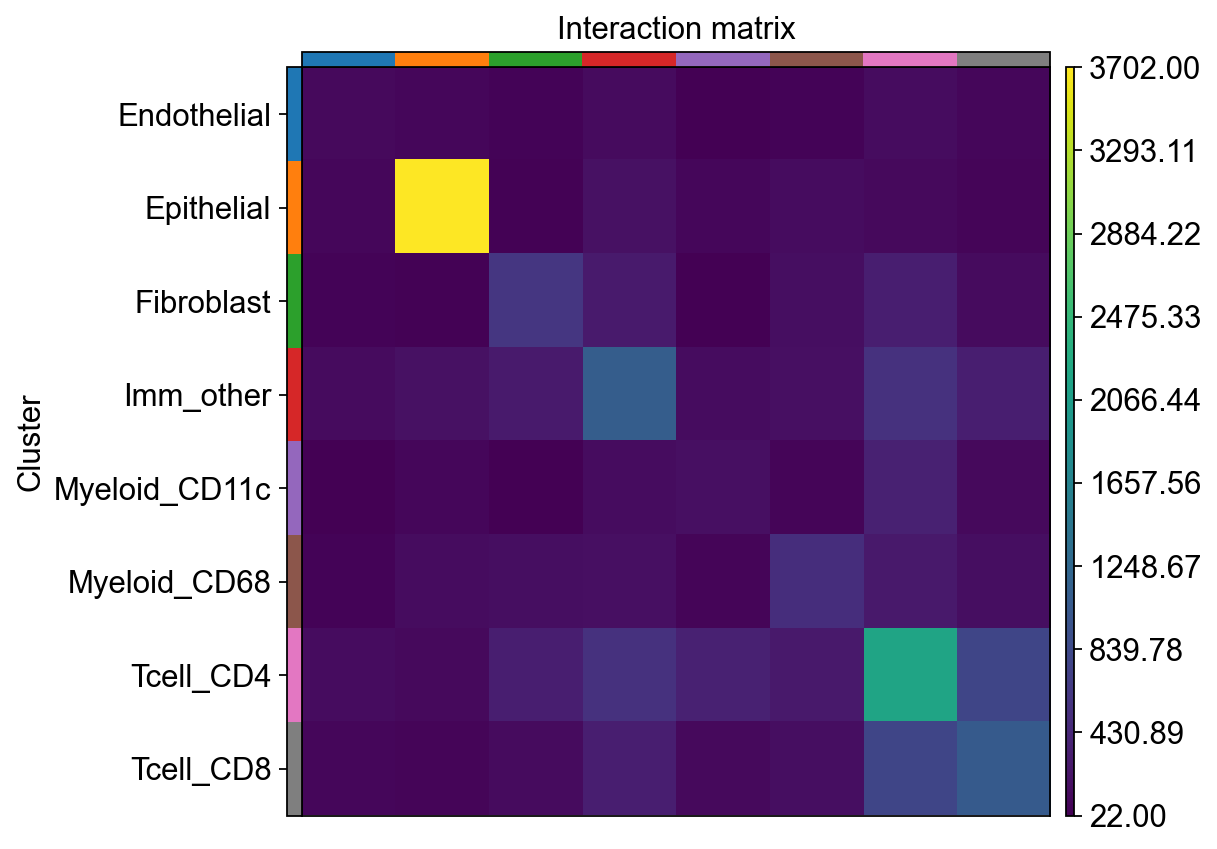

In [38]:
sq.gr.interaction_matrix(mibitof, cluster_key="Cluster")
sq.pl.interaction_matrix(mibitof, cluster_key="Cluster")

For the `mibitof` dataset we can see that, similarly to the neighborhood enrichment test, the `Epithelial` cluster is tightly self connected, and also the T cell clusters `Tcell_CD4` and `Tcell_CD8` also seem to share an high degree of connection.

/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


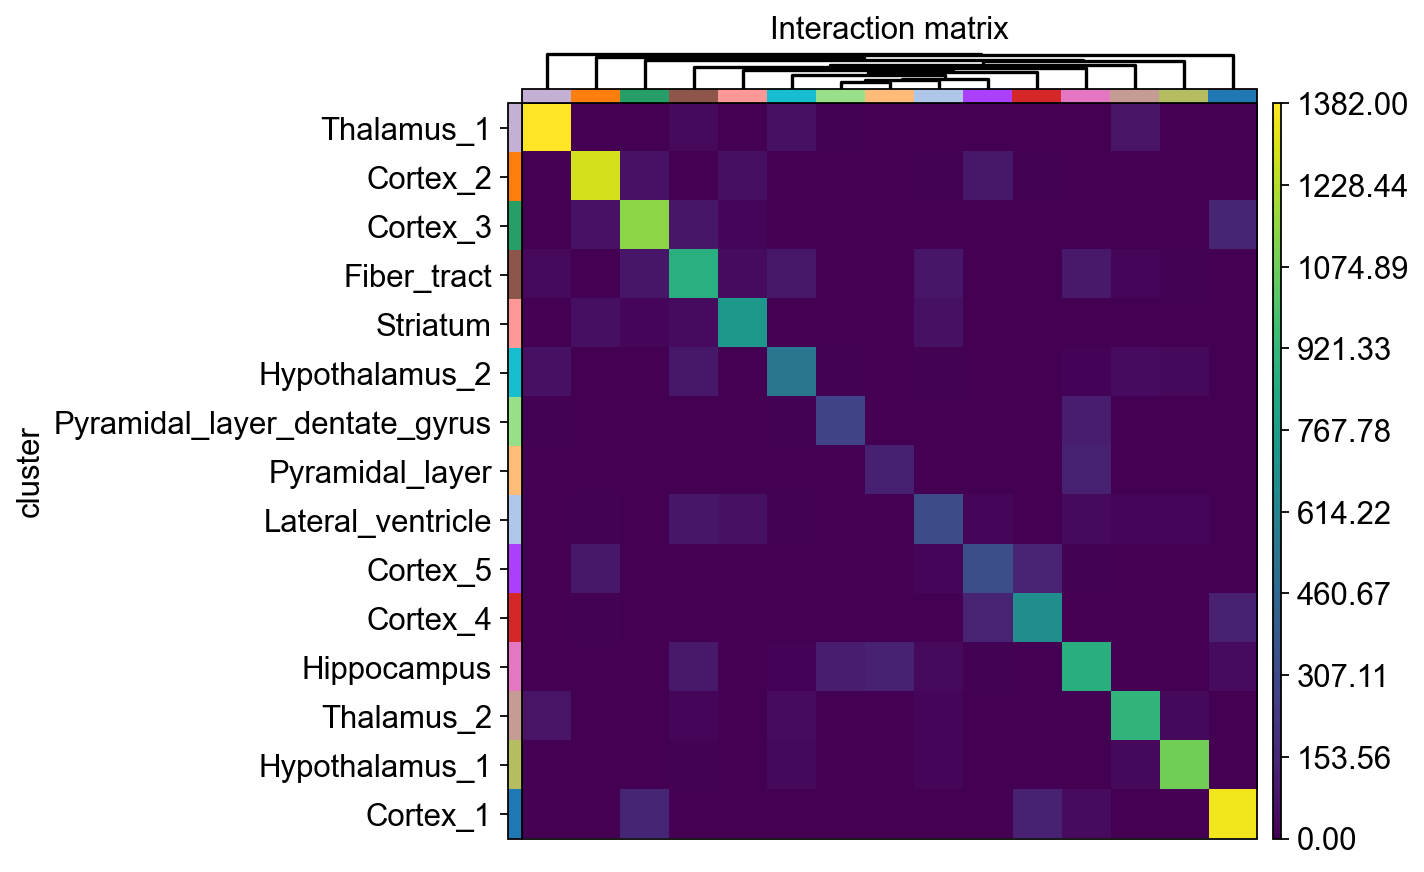

In [40]:
sq.gr.interaction_matrix(visium, cluster_key="cluster")
sq.pl.interaction_matrix(
    visium, cluster_key="cluster", method="average", figsize=(5, 5)
)

For the `visium` dataset instead, we roughly recapitulate the neighborhood enrichment test, yet we seem to not observe a particularly strong interaction between the `Pyramidal_layer` and `Dentate_gyrus` clusters. 
One explanation for such result is that the number of observations of such cluster is low, hence the low number of interactions.

## Co-occurrence across spatial dimensions

Another spatial statistics that can be computed on cell type annotations in spatial coordiantes is what we call the co-occurrence score. The co-occurrence score gives us an indication on whether clusters co-occurr with each other at increasing distances across the tissue.
The co-occurrence score is defined as:

$\frac{p(exp|cond)}{p(exp)}$

where $p(exp|cond)$ is the conditional probability of observing a cluster $exp$ conditioned
on the presence of a cluster $cond$ whereas $exp$ is the probability of observing $exp$
in the radius size of interest. The score is computed across increasing radii size around each observation (i.e. spots here) in the tissue.



100%|██████████| 1/1 [00:06<00:00,  6.95s/]


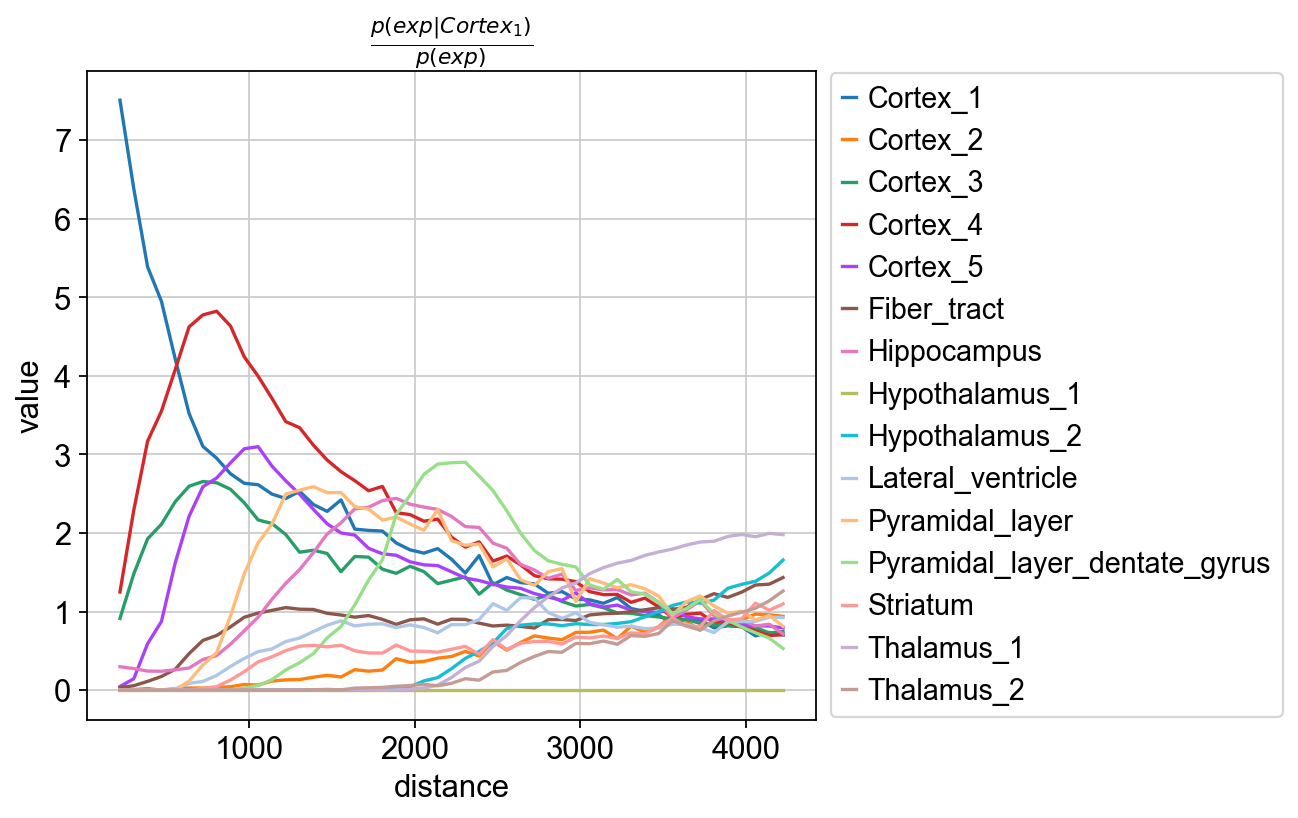

In [47]:
sq.gr.co_occurrence(visium, cluster_key="cluster")
sq.pl.co_occurrence(visium, cluster_key="cluster", clusters="Cortex_1", figsize=(8, 5))

Here, we selected to visualize the cluster `Cortex_1` to visualize how at close distances, the cluster co-occurr with the other `Cortex` clusters, as expected.